# Road Lane line detection

## Import packages

In [1]:
# importing packages

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Read a image

(540, 960, 3)


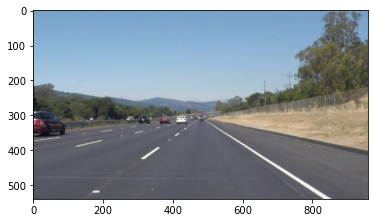

In [2]:
image = mpimg.imread('image.jpg')
print(image.shape)
plt.imshow(image)

- cv2.inRange() for color selection
- cv2.fillPoly() for regions selection
- cv2.line() to draw lines on an image given endpoints
- cv2.addWeighted() to coadd / overlay two images 
- cv2.cvtColor() to grayscale or change color 
- cv2.imwrite() to output images to file
- cv2.bitwise_and() to apply a mask to an image

In [3]:
# image masking - keeps the region of the image defined by the polygon formed from vertices
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        ignore_mask_color = (255,) * img.shape[2]
    else:
        ignore_mask_color = 255
           
    cv2.fillPoly(mask , vertices, ignore_mask_color)
    
    return (cv2.bitwise_and(img,mask))
    

In [4]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    
    imshape = img.shape
    left_lines = []
    right_lines = []
    left_lines_aligned = []
    right_lines_aligned = []
    left_m = []
    left_b = []
    right_m = []
    right_b = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            b = y1 - (m * x1)
            #left line
            if m < 0: left_lines.append((m,b)) 
            #right line    
            if m > 0: right_lines.append((m,b)) 
                
    #calculate the average and standard deviation for the left lines' slope            
    left_m = [line[0] for line in left_lines]
    left_m_avg = np.mean(left_m)
    left_m_std = np.std(left_m)
    
    #only keep lines that are close to the average slope
    for line in left_lines:
        if abs(line[0] - left_m_avg) < left_m_std:
            left_lines_aligned.append(line)
            
    #compute the average slope and intercept of the aligned left lines
    if len(left_lines_aligned) > 0:
        left_m = [line[0] for line in left_lines_aligned]
        ml = np.mean(left_m)
        left_b = [line[1] for line in left_lines_aligned]
        bl = np.mean(left_b)
    else:
        ml = left_m_avg
        left_b = [line[1] for line in left_lines]
        bl = np.mean(left_b)
    
    #similarly for right
    right_m = [line[0] for line in right_lines]
    right_m_avg = np.mean(right_m)
    right_m_std = np.std(right_m)
    
    for line in right_lines:
        if abs(line[0] - right_m_avg) < right_m_std:
            right_lines_aligned.append(line)
            
    if len(right_lines_aligned) > 0:
        right_m = [line[0] for line in right_lines_aligned]
        mr = np.mean(right_m)
        right_b = [line[1] for line in right_lines_aligned]
        br = np.mean(right_b)
    else:
        mr = right_m_avg
        right_b = [line[1] for line in right_lines]
        br = np.mean(right_b)

    smooth_fact = 0.8
    #only consider computed slope if angled enough
    if (abs(ml) < 1000):
        if (previous_lines[0] != 0):
            ml = previous_lines[0]*smooth_fact + ml*(1-smooth_fact)
            bl = previous_lines[1]*smooth_fact + bl*(1-smooth_fact)
    elif (previous_lines[0] != 0):
        ml = previous_lines[0]
        bl = previous_lines[1]
        
    if (abs(mr) < 1000):      
        if (previous_lines[2] != 0):
            mr = previous_lines[2]*smooth_fact + mr*(1-smooth_fact)
            br = previous_lines[3]*smooth_fact + br*(1-smooth_fact)
    elif (previous_lines[2] != 0):
        mr = previous_lines[2]
        br = previous_lines[3]
            
             
    #interpolate the resulting average line to intersect the edges of the region of interest
    #the two edges consider are y = 6*imshape[0]/10 (the middle edge)
    #                           y = imshape[0] (the bottom edge)        
    x1l = int((bl - imshape[0]) / (-1 * ml))
    y1l = imshape[0]    
    x2l = int((bl - 6*imshape[0]/10) / (-1 * ml))
    y2l = int(6*imshape[0]/10)      
        
    x1r = int((br - 6*imshape[0]/10) / (-1 * mr))
    y1r = int(6*imshape[0]/10)    
    x2r = int((br - imshape[0]) / (-1 * mr))
    y2r = imshape[0]      
        
    if (x2l < x1r):
        #draw the left line in green and right line in blue
        cv2.line(img, (x1l, y1l), (x2l, y2l), [0, 255, 0], thickness) 
        cv2.line(img, (x1r, y1r), (x2r, y2r), [0, 0, 255], thickness)
    
    #store lines coeficients for next cycle    
    previous_lines[0] = ml
    previous_lines[1] = bl
    previous_lines[2] = mr
    previous_lines[3] = br   

In [5]:
# converting pixels to  a line in Hough Transform space (img output of canny transform)
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

In [6]:
def weighted_img(img, initial_img, alpha=0.8, beta=0.6, gamma=0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

In [7]:
def process_image(img): 
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    #define two color masks for yellow and white
    mask_white = cv2.inRange(img, (200,200,200), (255, 255, 255))
    mask_yellow = cv2.inRange(hsv_img, (20,100,100), (30, 255, 255))
    color_mask = cv2.bitwise_or(mask_white, mask_yellow)
    masked_img = np.copy(img)
    masked_img[color_mask == 0] = [0,0,0]

    gray_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
    #to get rid of imperfections
    blurred_gray_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    #to detect edges 
    edges_from_img = cv2.Canny(blurred_gray_img, 50, 100)

    # selecting region of interest
    imshape = img.shape
#     vertices = np.array([[(0,imshape[0]), (20,20), (imshape[1]-20,20), (imshape[1],imshape[0])]], dtype = np.int32)
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2,imshape[0]/2) , (imshape[1],imshape[0])]], dtype = np.int32)
    roi_image = region_of_interest(edges_from_img, vertices)

     #apply Hough transform to color masked grayscale blurred image
    theta = np.pi/180       
    line_img = hough_lines(roi_image, 2, theta, 30, 100, 180)

    ### overlay image and lines ###
    overlay_img = weighted_img(line_img, img)
    return(overlay_img)

## for images

(540, 960, 3)


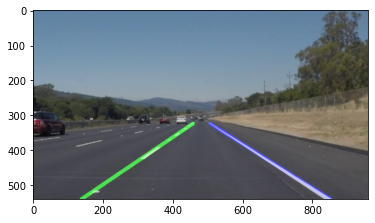

In [8]:
previous_lines = [0,0,0,0]
first_frame = 1

img = mpimg.imread('image.jpg')
print(img.shape)
img_out = process_image(img)
plt.imshow(img_out)


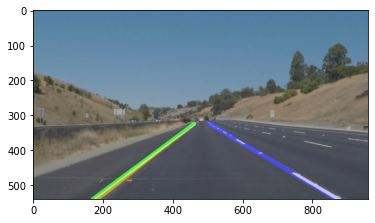

In [9]:
previous_lines = [0,0,0,0]
first_frame = 1

img_list = os.listdir("images/")
for i in range (len(img_list)):
    img_name = img_list[i]
    if img_name[-3:] == 'jpg' :
        import_from = 'images/' + img_name  
        img_in = mpimg.imread(import_from)
        img_out = process_image(img_in)
        export_to = 'images_output/' + 'lanes_marked_' + img_name
        plt.imsave(export_to, img_out)

## videos

In [10]:
def process_video(image):
    result = process_image(image)
    return (result)

In [11]:
previous_lines = [0, 0, 0, 0]
first_frame = 1
white_output = 'processed_video.mp4'
clip1 = VideoFileClip("video.mp4")
white_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
previous_lines = [0, 0, 0, 0]


HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Moviepy - Building video processed_video.mp4.
Moviepy - Writing video processed_video.mp4



Moviepy - Done !
Moviepy - video ready processed_video.mp4
Wall time: 46.2 s


In [12]:
previous_lines = [0,0,0,0]
first_frame = 1

vid_list = os.listdir("videos/")
for i in range (len(vid_list)):
    vid_name = vid_list[i]
    if vid_name[-3:] == 'mp4' :
        import_from = 'videos/' + vid_name  
        clip_in = VideoFileClip(import_from)
        clip_out = clip_in.fl_image(process_video) #NOTE: this function expects color images!!
        export_to = 'videos_output/' + 'lanes_marked_' + vid_name
        %time clip_out.write_videofile(export_to, audio=False)

t:   0%|                                                                             | 0/251 [00:00<?, ?it/s, now=None]

Moviepy - Building video videos_output/lanes_marked_video_1.mp4.
Moviepy - Writing video videos_output/lanes_marked_video_1.mp4



Moviepy - Done !
Moviepy - video ready videos_output/lanes_marked_video_1.mp4
Wall time: 32.9 s


t:   0%|                                                                             | 0/221 [00:00<?, ?it/s, now=None]

Moviepy - Building video videos_output/lanes_marked_video_2.mp4.
Moviepy - Writing video videos_output/lanes_marked_video_2.mp4



Moviepy - Done !
Moviepy - video ready videos_output/lanes_marked_video_2.mp4
Wall time: 14.8 s


t:   0%|                                                                             | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video videos_output/lanes_marked_video_3.mp4.
Moviepy - Writing video videos_output/lanes_marked_video_3.mp4



Moviepy - Done !
Moviepy - video ready videos_output/lanes_marked_video_3.mp4
Wall time: 33.6 s
